In [1]:
from configs import Config

config_mbf = Config(model_name='mbf_large', 
                    target_ckpt_path='weights/backbone/mbf_large.pt', 
                    shadow_ckpt_path='weights/shadow/mbf_large.ckpt')

config_dp_mbf = Config(model_name='dp_mbf_large', 
                       target_ckpt_path='weights/backbone/dp_mbf_large.pt', 
                       shadow_ckpt_path='weights/shadow/dp_mbf_large.ckpt')

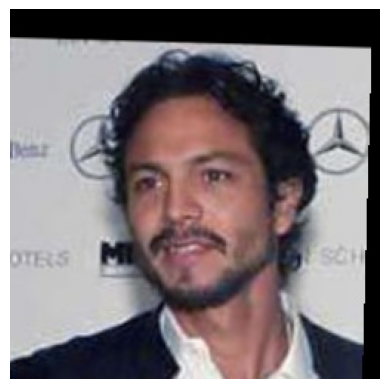

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
img_path = 'dataset/lfw-py/lfw_funneled/Benjamin_Bratt/Benjamin_Bratt_0001.jpg'
img = Image.open(img_path)
plt.axis('off')
plt.imshow(img)

2024-02-28 13:42:11.706643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 13:42:11.706692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 13:42:11.707321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 13:42:11.710977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 13:42:13.154524: W tensorflow/compiler/tf2

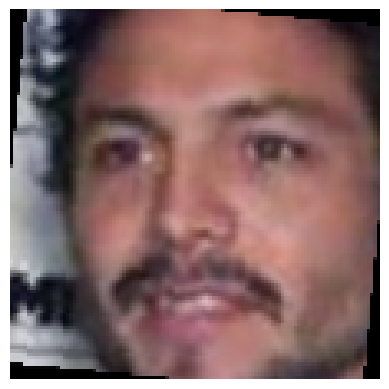

In [3]:
# Extract the face from the image
from dataset import extract_face
face = extract_face(img)
plt.axis('off')
plt.imshow(face[:,:,::-1])

In [4]:
from model import get_backbone, get_shadow
backbone = get_backbone(config_mbf)
backbone_dp = get_backbone(config_dp_mbf)

shadow = get_shadow(config_mbf, backbone, None)
shadow_dp = get_shadow(config_dp_mbf, backbone_dp, None)

Loaded the checkpoint from weights/backbone/mbf_large.pt
Loaded the checkpoint from weights/backbone/dp_mbf_large.pt
Loaded the checkpoint from weights/shadow/mbf_large.ckpt
Loaded the checkpoint from weights/shadow/dp_mbf_large.ckpt


In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
backbone.eval().to(device)
backbone_dp.eval().to(device)
shadow.eval().to(device)
shadow_dp.eval().to(device)
print(f"Move all model to {device}")

Move all model to cuda


In [6]:
# turn the image to tensor
from torchvision import transforms as T
transform = T.ToTensor()
img_tensor = transform(face).unsqueeze(0).to(device)
print(img_tensor.shape)

torch.Size([1, 3, 112, 112])


In [7]:
backbone.eval().to(device)
feat = backbone(img_tensor)
print(f'{feat.shape=}')

backbone_dp.eval().to(device)
feat_dp = backbone_dp(img_tensor)
print(f'{feat_dp.shape=}')

feat.shape=torch.Size([1, 512])
feat_dp.shape=torch.Size([1, 512])


In [8]:
rec_tensor = shadow(feat)[0]
print(f'{rec_tensor.shape=}')

rec_tensor_dp = shadow_dp(feat_dp)[0]
print(f'{rec_tensor_dp.shape=}')

rec_tensor_cross = shadow(feat_dp)[0]
print(f'{rec_tensor_cross.shape=}')

rec_tensor_cross2 = shadow_dp(feat)[0]
print(f'{rec_tensor_cross2.shape=}')

rec_tensor.shape=torch.Size([3, 112, 112])
rec_tensor_dp.shape=torch.Size([3, 112, 112])
rec_tensor_cross.shape=torch.Size([3, 112, 112])
rec_tensor_cross2.shape=torch.Size([3, 112, 112])


In [9]:
import cv2
import numpy as np

def tensor2img(tensor: torch.Tensor):
    tensor = tensor.permute(1, 2, 0) * 255
    ndarray = tensor.cpu().detach().numpy().astype(np.uint8)
    img = cv2.cvtColor(ndarray, cv2.COLOR_BGR2RGB)
    return img

In [10]:
img_rec = tensor2img(rec_tensor)
img_rec_dp = tensor2img(rec_tensor_dp)
img_rec_cross = tensor2img(rec_tensor_cross)
img_rec_cross2 = tensor2img(rec_tensor_cross2)

Text(0.5, 1.0, 'DP-feat + shadow')

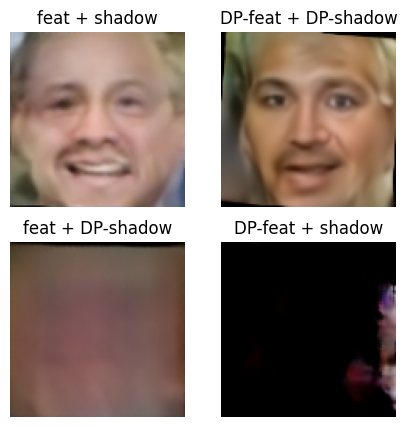

In [11]:
plt.subplots(2, 2, figsize=(5, 5))

plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(img_rec)
plt.title('feat + shadow')

plt.subplot(2, 2, 2)
plt.axis('off')
plt.imshow(img_rec_dp)
plt.title('DP-feat + DP-shadow')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.imshow(img_rec_cross)
plt.title('feat + DP-shadow')

plt.subplot(2, 2, 4)
plt.axis('off')
plt.imshow(img_rec_cross2)
plt.title('DP-feat + shadow')

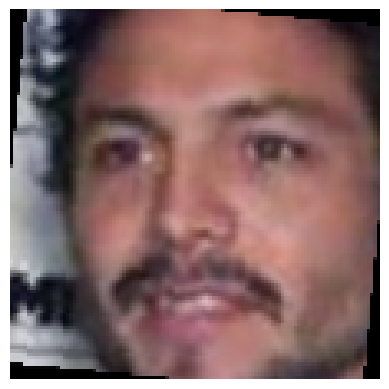

In [12]:
plt.axis('off')
plt.imshow(face[:,:,::-1])